In [10]:
# install packages


# import packages

import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import pickle
#hmm
from hmmlearn import hmm



# format

# def stock_data(stock_name -> str):

# Return train_data, test_data 


# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 


# def evaluation(test_data -> np.array, prediction -> np.array):
	
# 	Return metrics


# evaluation

In [11]:
def reject_outliers(data, m=1.5):
    ceiling = np.mean(data)+ m * np.std(data)
    floor = np.mean(data)- m * np.std(data)
    
    return np.clip(data,a_min = floor, a_max = ceiling)

In [12]:
def evaluation_metrics(test_data, predictions):
    metrics = {}
    
    metrics['MAPE'] = mean_absolute_percentage_error(predictions,test_data)
    metrics['MSE'] = mean_squared_error(test_data,predictions)
    
    return metrics

# Models

In [13]:
def hmm_prediction(train_data,num_of_predictions):
    hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
    hmm_model.fit(train_data)
    
    predict_state = hmm_model.predict(train_data)
    
    hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
    hmm_prediction_value = hmm_prediction[0]
    hmm_prediction_states = hmm_prediction[1]
    
    return hmm_prediction_value

# Pipeline

In [45]:
a_file = open('processed_data/' + 'micro' + '_test.pkl', "rb")
test_data = pickle.load(a_file)

In [48]:
pd.DataFrame(test_data['NH'])

,0,1
0,2021-01-04,-0.050381
1,2021-01-05,0.029328
2,2021-01-06,-0.055007
3,2021-01-07,-0.033244
4,2021-01-08,0.085279
...,...,...
232,2021-12-03,-0.019418
233,2021-12-06,-0.05609
234,2021-12-07,0.0
235,2021-12-08,0.037041


In [16]:
cap_list = ['nano','micro','small','medium','large','mega']

In [35]:
metrics_df_concat = pd.DataFrame()

for cap_size in cap_list:
    result_metric_dict = {}
    
    a_file = open('processed_data/' + cap_size + '_train.pkl', "rb")
    train_data = pickle.load(a_file)
    
    a_file = open('processed_data/' + cap_size + '_test.pkl', "rb")
    test_data = pickle.load(a_file)
    
    
    for stock_ticker in train_data.keys():
        #print(stock_ticker)
        model_input = np.array(pd.DataFrame(train_data[stock_ticker]).dropna()[1])
        actual_values = np.array(pd.DataFrame(test_data[stock_ticker]).dropna()[1])
        
        prediction = hmm_prediction(model_input.reshape(-1,1),len(actual_values))
        result_metric_dict[stock_ticker] = evaluation_metrics(actual_values.reshape(-1,1),prediction)

    metrics_df = pd.DataFrame(result_metric_dict).T
    metrics_df['Cap_size'] = cap_size
    
    metrics_df_concat = metrics_df_concat.append(metrics_df)

In [36]:
metrics_df_concat

,MAPE,MSE,Cap_size
WVVIP,7.492250,0.001421,nano
CBIO,3.704746,0.004335,nano
CYCCP,10.780292,0.003053,nano
CLRB,3.947402,0.003386,nano
NSYS,5.953601,0.004825,nano
...,...,...,...
CSCO,2.970620,0.000437,mega
CMCSA,3.652724,0.000573,mega
INTC,3.435696,0.000838,mega
NFLX,2.972472,0.001513,mega


#  MAPE by cap

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

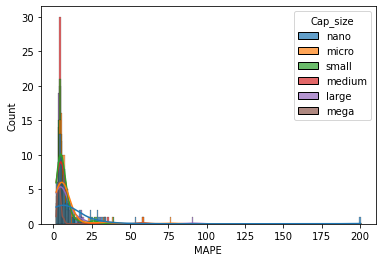

In [37]:
sns.histplot(data = metrics_df_concat
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

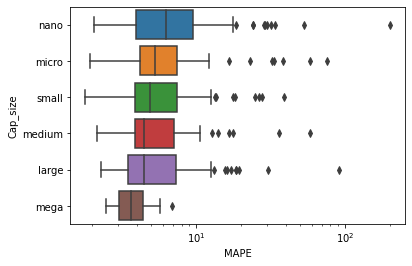

In [38]:
sns.boxplot(data = metrics_df_concat
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
plt.xscale('log')

In [39]:
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

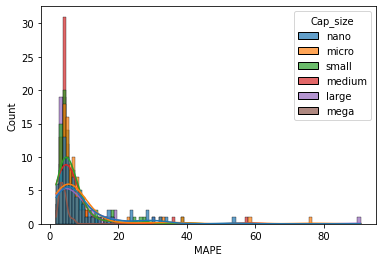

In [40]:
sns.histplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

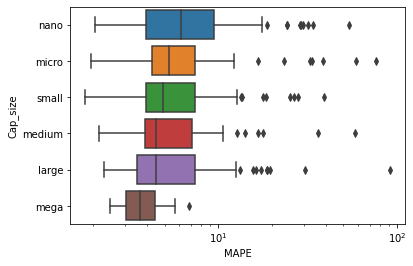

In [41]:
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
plt.xscale('log')

# MSE by cap

<AxesSubplot:xlabel='MSE', ylabel='Cap_size'>

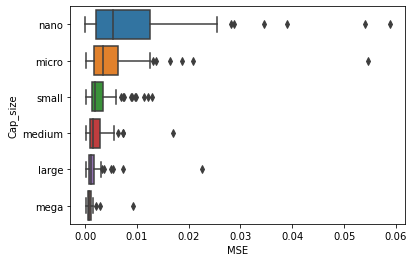

In [42]:
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MSE'
            ,y = 'Cap_size'
            )

# statistics

In [43]:
metrics_df_concat.groupby('Cap_size').mean().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,11.474003,0.009196
micro,8.408632,0.005283
small,6.872338,0.002958
medium,6.498848,0.002199
large,7.514640,0.001694
mega,3.878623,0.001414


In [44]:
metrics_df_concat.groupby('Cap_size').std().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,23.005395,0.011095
micro,11.077378,0.006764
small,5.869565,0.002702
medium,7.066218,0.002167
large,10.693661,0.002667
mega,1.107321,0.002016
